**# STEP 1 – Environment Setup + Mount Drive + Install + Confirm**

In [1]:
# STEP 1 — Clean Prophet Environment Setup
# Required to restart Runtime in order to fit prophet ==1.1.7


from google.colab import drive
drive.mount('/content/drive')

# Uninstall old packages that conflict with Prophet
!pip uninstall -y numpy pandas scipy scikit-learn cmdstanpy prophet pystan

# Reinstall Prophet with compatible versions
!pip install --quiet --no-cache-dir \
    numpy==1.26.4 \
    pandas==2.2.2 \
    scipy==1.13.1 \
    scikit-learn==1.5.2 \
    prophet==1.1.5

# Suppress warnings for cleaner output
import warnings, logging
warnings.filterwarnings("ignore")
logging.getLogger("prophet").setLevel(logging.ERROR)
logging.getLogger("cmdstanpy").setLevel(logging.ERROR)

# Confirm versions
import numpy as np, pandas as pd, scipy, prophet

print("✅ NumPy:", np.__version__)
print("✅ pandas:", pd.__version__)
print("✅ SciPy:", scipy.__version__)
print("✅ Prophet:", prophet.__version__)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
Found existing installation: scipy 1.13.1
Uninstalling scipy-1.13.1:
  Successfully uninstalled scipy-1.13.1
Found existing installation: scikit-learn 1.5.2
Uninstalling scikit-learn-1.5.2:
  Successfully uninstalled scikit-learn-1.5.2
Found existing installation: cmdstanpy 1.3.0
Uninstalling cmdstanpy-1.3.0:
  Successfully uninstalled cmdstanpy-1.3.0
Found existing installation: prophet 1.1.5
Uninstalling prophet-1.1.5:
  Successfully uninstalled prophet-1.1.5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 276.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━

**STEP 2 – Define project paths & folders**

In [ ]:
# STEP 2 – Define Base Project Paths

import os

BASE = "/content/drive/My Drive/GoldForecasting_Project (ISY5002)"
DATA = os.path.join(BASE, "Data")
MODELS_ARIMA = os.path.join(BASE, "Models", "ARIMA")
MODELS_TCN = os.path.join(BASE, "Models", "TCN")
MODELS_PROPHET = os.path.join(BASE, "Models", "Prophet")
NOTEBOOKS = os.path.join(BASE, "Notebooks")
OUTPUTS = os.path.join(BASE, "Outputs")

# Create folders if they don’t exist
for d in [DATA, MODELS_ARIMA, MODELS_TCN, MODELS_PROPHET, NOTEBOOKS, OUTPUTS]:
    os.makedirs(d, exist_ok=True)

print("📂 Data:", DATA)
print("📂 Models_ARIMA:", MODELS_ARIMA)
print("📂 Models_TCN:", MODELS_TCN)
print("📂 Models_Prophet:", MODELS_PROPHET)
print("📂 Notebooks:", NOTEBOOKS)
print("📂 Outputs:", OUTPUTS)


📂 Data: /content/drive/My Drive/GoldForecasting_Project (ISY5002)/Data
📂 Models_ARIMA: /content/drive/My Drive/GoldForecasting_Project (ISY5002)/Models/ARIMA
📂 Models_TCN: /content/drive/My Drive/GoldForecasting_Project (ISY5002)/Models/TCN
📂 Models_Prophet: /content/drive/My Drive/GoldForecasting_Project (ISY5002)/Models/Prophet
📂 Notebooks: /content/drive/My Drive/GoldForecasting_Project (ISY5002)/Notebooks
📂 Outputs: /content/drive/My Drive/GoldForecasting_Project (ISY5002)/Outputs


**STEP 3 – Load & clean dataset**

In [3]:
import os
file_path = os.path.join(DATA, "XAU_USD Historical Price Data_2021-2025.csv")
df = pd.read_csv(file_path)

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.columns = df.columns.str.strip()

# Ensure numeric (remove commas/% etc.)
for col in ['Price','Open','High','Low']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(r'[^\d\.\-]', '', regex=True), errors='coerce')
if 'Change %' in df.columns:
    df['Change'] = df['Change %'].str.replace('%','').astype(float)

df = df.dropna(subset=['Price'])
df.head()


,Date,Price,Open,High,Low,Vol.,Change %,Change
1198,2021-01-01,1898.10,1897.69,1899.12,1897.39,NaN,0.09%,0.09
1197,2021-01-04,1942.28,1906.05,1944.65,1905.36,NaN,2.33%,2.33
1196,2021-01-05,1949.35,1942.65,1953.17,1934.08,NaN,0.36%,0.36
1195,2021-01-06,1918.81,1950.30,1959.60,1901.11,NaN,-1.57%,-1.57
1194,2021-01-07,1912.50,1919.40,1927.97,1906.86,NaN,-0.33%,-0.33


**STEP 4 - Convert your cleaned dataset for Prophet**

In [4]:

df_prophet = df.rename(columns={"Date": "ds", "Price": "y"})[["ds", "y"]]

print("✅ Prophet dataset ready:")
print(df_prophet.head())


✅ Prophet dataset ready:
             ds        y
1198 2021-01-01  1898.10
1197 2021-01-04  1942.28
1196 2021-01-05  1949.35
1195 2021-01-06  1918.81
1194 2021-01-07  1912.50


**STEP 5 – Prepare Prophet (data + folders)**

In [5]:
# If 'prophet' import fails, uncomment the next line:
# !pip install prophet --quiet

import os, logging
from prophet import Prophet

# Create a Prophet models folder to mirror TCN/ARIMA structure
MODELS_PROPHET = os.path.join(BASE, "Models", "Prophet")
os.makedirs(MODELS_PROPHET, exist_ok=True)

# Silence verbose logs from cmdstan/prophet (optional)
logging.getLogger("cmdstanpy").setLevel(logging.ERROR)
logging.getLogger("prophet").setLevel(logging.ERROR)

# Build Prophet dataframe (ds=date, y=value) from your cleaned df
prophet_df = df[['Date','Price']].copy().rename(columns={'Date':'ds','Price':'y'})
prophet_df = prophet_df.sort_values('ds')

# Enforce daily regularity & forward-fill gaps
prophet_df = prophet_df.set_index('ds').asfreq('D').ffill().reset_index()

# Split = 70/15/15 to match TCN/ARIMA
n = len(prophet_df)
train_size = int(n*0.70)
val_size   = int(n*0.15)

train_df = prophet_df.iloc[:train_size]
val_df   = prophet_df.iloc[train_size:train_size+val_size]
test_df  = prophet_df.iloc[train_size+val_size:]

print(len(train_df), len(val_df), len(test_df))


1178 252 254


In [6]:
# Clean reinstallation of Prophet and backend
!pip install --quiet prophet==1.1.5 cmdstanpy==1.2.4

# Rebuild cmdstan backend once (only needed the first time)
from cmdstanpy import install_cmdstan
install_cmdstan()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 5.0 MB/s eta 0:00:00
CmdStan install directory: /root/.cmdstan
Installing CmdStan version: 2.37.0
Download successful, file: /tmp/tmp1jfjegtf
Extracting distribution


DEBUG:cmdstanpy:cmd: make build -j1
cwd: None


Unpacked download as cmdstan-2.37.0
Building version cmdstan-2.37.0, may take several minutes, depending on your system.


DEBUG:cmdstanpy:cmd: make examples/bernoulli/bernoulli
cwd: None


Installed cmdstan-2.37.0
Test model compilation


True

**STEP 6 – Train Prophet on Train set**

In [7]:
# Initialize & train Prophet model
m = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True
)
m.fit(train_df)


DEBUG:cmdstanpy:input tempfile: /tmp/tmp7bpd5s2q/jkal4nvx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7bpd5s2q/vzkyklpl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45578', 'data', 'file=/tmp/tmp7bpd5s2q/jkal4nvx.json', 'init=/tmp/tmp7bpd5s2q/vzkyklpl.json', 'output', 'file=/tmp/tmp7bpd5s2q/prophet_modelu4b42tju/prophet_model-20251026135402.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:54:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:54:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


**STEP 7 – Forecast on Validation set**

Validation RMSE: 368.33 | MAE: 330.62


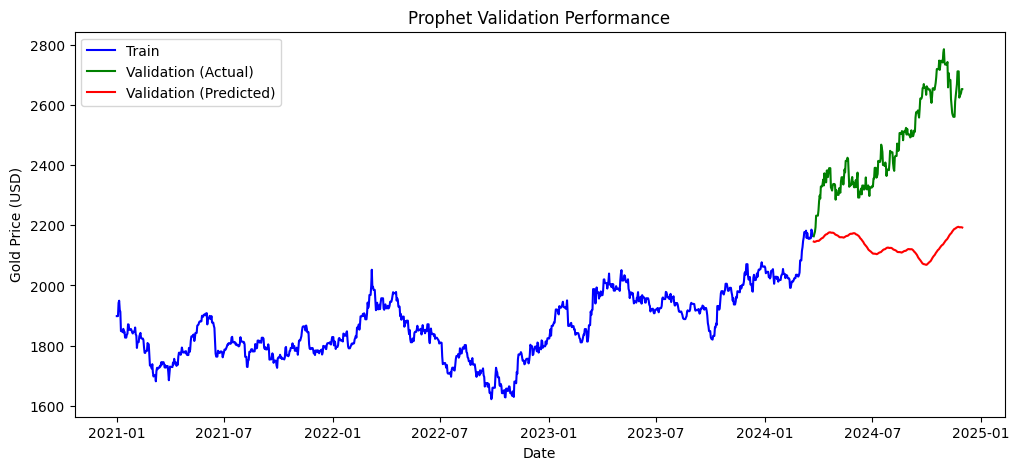

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Forecast validation horizon
future_val   = m.make_future_dataframe(periods=len(val_df), freq='D')
forecast_val = m.predict(future_val)

# Extract only validation slice
val_pred = forecast_val[['ds','yhat']].tail(len(val_df)).set_index('ds')['yhat']

# Metrics
rmse_val = np.sqrt(mean_squared_error(val_df['y'].values, val_pred.values))
mae_val  = mean_absolute_error(val_df['y'].values, val_pred.values)
print(f"Validation RMSE: {rmse_val:.2f} | MAE: {mae_val:.2f}")

# Plot
plt.figure(figsize=(12,5))
plt.plot(train_df['ds'], train_df['y'], label="Train", color="blue")
plt.plot(val_df['ds'], val_df['y'], label="Validation (Actual)", color="green")
plt.plot(val_pred.index, val_pred, label="Validation (Predicted)", color="red")
plt.title("Prophet Validation Performance")
plt.xlabel("Date"); plt.ylabel("Gold Price (USD)")
plt.legend(); plt.show()


**STEP 8 – Retrain on Train+Validation, Evaluate on Test)**

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7bpd5s2q/zazgrgr4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7bpd5s2q/0u2luryz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22268', 'data', 'file=/tmp/tmp7bpd5s2q/zazgrgr4.json', 'init=/tmp/tmp7bpd5s2q/0u2luryz.json', 'output', 'file=/tmp/tmp7bpd5s2q/prophet_model6qdyj9pd/prophet_model-20251026135410.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:54:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:54:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Test RMSE: 121.00 | MAE: 97.49


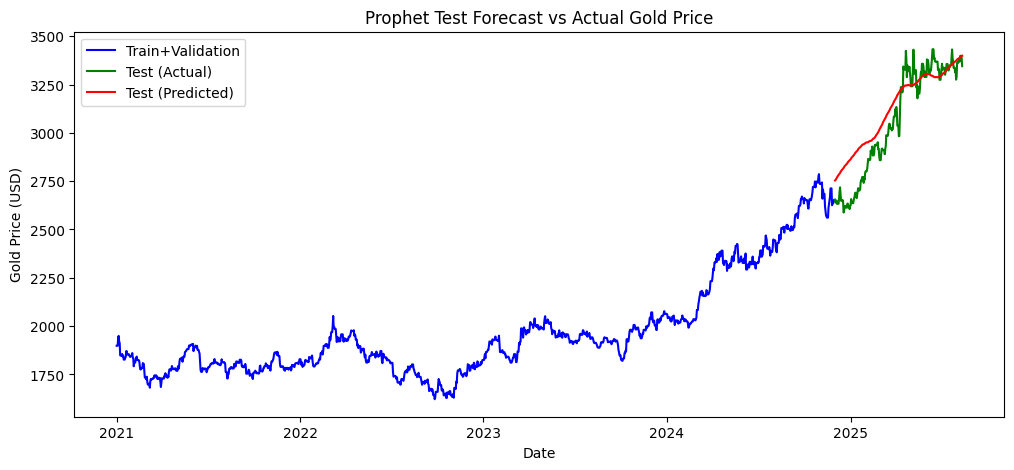

In [9]:
# Retrain Prophet on Train+Validation
train_val_df = prophet_df.iloc[:train_size+val_size]

final_model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True
)
final_model.fit(train_val_df)

# Forecast test horizon
future_test   = final_model.make_future_dataframe(periods=len(test_df), freq='D')
forecast_test = final_model.predict(future_test)

# Extract test predictions
test_pred = forecast_test[['ds','yhat']].tail(len(test_df)).set_index('ds')['yhat']

# Metrics
rmse_test = np.sqrt(mean_squared_error(test_df['y'].values, test_pred.values))
mae_test  = mean_absolute_error(test_df['y'].values, test_pred.values)
print(f"Test RMSE: {rmse_test:.2f} | MAE: {mae_test:.2f}")

# Plot
plt.figure(figsize=(12,5))
plt.plot(train_val_df['ds'], train_val_df['y'], label="Train+Validation", color="blue")
plt.plot(test_df['ds'], test_df['y'], label="Test (Actual)", color="green")
plt.plot(test_pred.index, test_pred, label="Test (Predicted)", color="red")
plt.title("Prophet Test Forecast vs Actual Gold Price")
plt.xlabel("Date"); plt.ylabel("Gold Price (USD)")
plt.legend(); plt.show()


**STEP 9 – Forecast Next 30 Days (with Confidence Interval)**

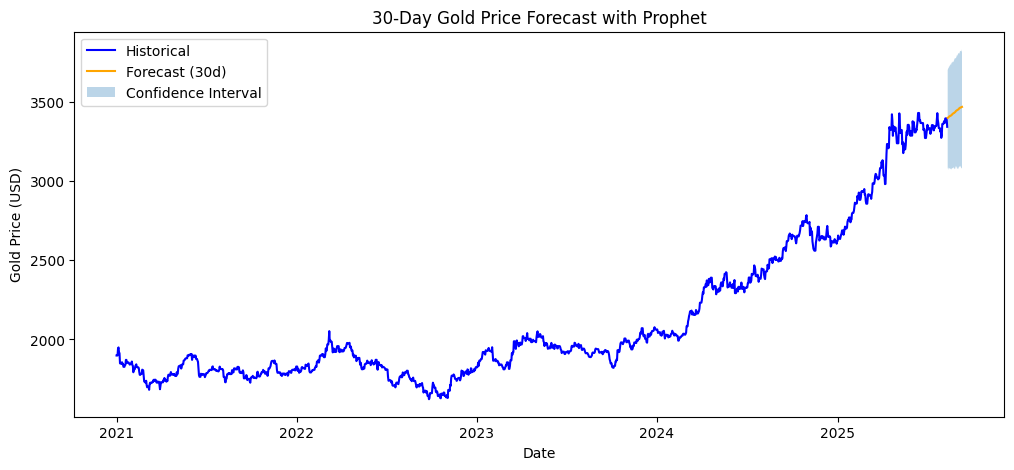

,ds,yhat,yhat_lower,yhat_upper
1684,2025-08-12,3401.376058,3087.423350,3703.974347
1685,2025-08-13,3403.212157,3073.098483,3714.806093
1686,2025-08-14,3406.894436,3087.585582,3717.329728
1687,2025-08-15,3410.228770,3083.019094,3732.645176
1688,2025-08-16,3411.917020,3081.198233,3722.616178


In [10]:
# Extend forecast by 30 days beyond test
future_30   = final_model.make_future_dataframe(periods=len(test_df)+30, freq='D')
forecast_30 = final_model.predict(future_30)

# Extract last 30 days forecast
future_pred = forecast_30[['ds','yhat','yhat_lower','yhat_upper']].tail(30)

# Plot forecast with CI
plt.figure(figsize=(12,5))
plt.plot(prophet_df['ds'], prophet_df['y'], label="Historical", color="blue")
plt.plot(future_pred['ds'], future_pred['yhat'], label="Forecast (30d)", color="orange")
plt.fill_between(future_pred['ds'],
                 future_pred['yhat_lower'],
                 future_pred['yhat_upper'],
                 alpha=0.3, label="Confidence Interval")
plt.title("30-Day Gold Price Forecast with Prophet")
plt.xlabel("Date"); plt.ylabel("Gold Price (USD)")
plt.legend(); plt.show()

future_pred.head()


**STEP 10 – Directional Accuracy & Confusion Matrix (Prophet)**

Directional Accuracy (Prophet, Test): 40.32%


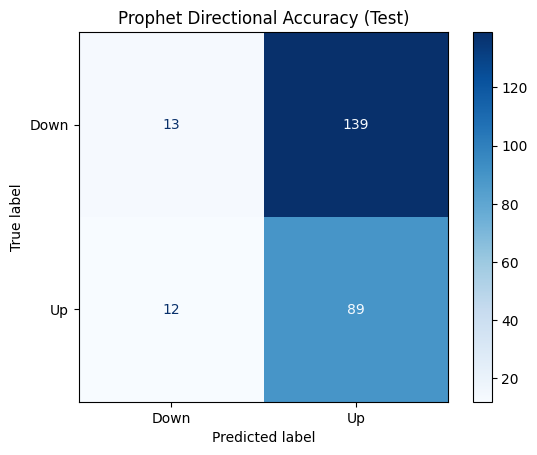

In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Align actual and predicted values on test set
y_true = test_df.set_index('ds')['y'].loc[test_pred.index].values
y_pred = test_pred.values

# Convert to directional movement: 1 = Up, 0 = Down
actual_dir = (y_true[1:] > y_true[:-1]).astype(int)
pred_dir   = (y_pred[1:] > y_pred[:-1]).astype(int)

# Directional Accuracy
acc = accuracy_score(actual_dir, pred_dir)
print(f"Directional Accuracy (Prophet, Test): {acc:.2%}")

# Confusion Matrix
cm = confusion_matrix(actual_dir, pred_dir)
disp = ConfusionMatrixDisplay(cm, display_labels=["Down","Up"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Prophet Directional Accuracy (Test)")
plt.show()


In [12]:
# ==============================================================
# STEP 11 – Save Prophet Model, Forecast Output & requirements.txt
# ==============================================================

import os
import joblib
import pandas as pd
import pkg_resources
from pathlib import Path

# Base project path (same as earlier)
BASE = "/content/drive/My Drive/GoldForecasting_Project (ISY5002)"
MODELS_PROPHET = os.path.join(BASE, "Models", "Prophet")
os.makedirs(MODELS_PROPHET, exist_ok=True)

# --------------------------------------------------------------
# 1️⃣ Save trained Prophet model
# --------------------------------------------------------------
prophet_model_path = os.path.join(MODELS_PROPHET, "prophet_model.joblib")
joblib.dump(final_model, prophet_model_path)
print(f"✅ Prophet model saved successfully at:\n{prophet_model_path}")

# --------------------------------------------------------------
# 2️⃣ Save forecast output (actual vs predicted)
# --------------------------------------------------------------
prophet_output_path = os.path.join(MODELS_PROPHET, "prophet_output.csv")

output_df = pd.DataFrame({
    "Date": test_df["ds"],
    "Actual_Close_USD": test_df["y"],
    "Predicted_Close_USD": test_pred.values
})
output_df.to_csv(prophet_output_path, index=False)
print(f"✅ Prophet forecast output saved successfully at:\n{prophet_output_path}")

# --------------------------------------------------------------
# 3️⃣ Save requirements.txt
# --------------------------------------------------------------
requirements_path = os.path.join(MODELS_PROPHET, "requirements.txt")
required = ["numpy", "pandas", "scipy", "prophet", "joblib"]

with open(requirements_path, "w") as f:
    for pkg in required:
        try:
            version = pkg_resources.get_distribution(pkg).version
            f.write(f"{pkg}=={version}\n")
        except pkg_resources.DistributionNotFound:
            f.write(f"{pkg}\n")

print(f"✅ requirements.txt saved successfully at:\n{requirements_path}")

# --------------------------------------------------------------
# 4️⃣ Verify files
# --------------------------------------------------------------
if (Path(prophet_model_path).exists() and
    Path(prophet_output_path).exists() and
    Path(requirements_path).exists()):
    print("\n🎯 All files created successfully:")
    print(f"   • Model: {prophet_model_path}")
    print(f"   • Output: {prophet_output_path}")
    print(f"   • Requirements: {requirements_path}")
else:
    print("⚠️ Something went wrong — please check folder paths.")


✅ Prophet model saved successfully at:
/content/drive/My Drive/GoldForecasting_Project (ISY5002)/Models/Prophet/prophet_model.joblib
✅ Prophet forecast output saved successfully at:
/content/drive/My Drive/GoldForecasting_Project (ISY5002)/Models/Prophet/prophet_output.csv
✅ requirements.txt saved successfully at:
/content/drive/My Drive/GoldForecasting_Project (ISY5002)/Models/Prophet/requirements.txt

🎯 All files created successfully:
   • Model: /content/drive/My Drive/GoldForecasting_Project (ISY5002)/Models/Prophet/prophet_model.joblib
   • Output: /content/drive/My Drive/GoldForecasting_Project (ISY5002)/Models/Prophet/prophet_output.csv
   • Requirements: /content/drive/My Drive/GoldForecasting_Project (ISY5002)/Models/Prophet/requirements.txt
